# Модель Nelson–Siegel для моделирования кривой процентных ставок

Модель Nelson–Siegel (1987) — параметрическая модель для аппроксимации кривой доходности с использованием 4 параметров:

- β₀: уровень (долгосрочная ставка)  
- β₁: краткосрочный компонент (наклон)  
- β₂: среднесрочный компонент (кривизна)  
- τ: временной параметр (положение и ширина выпуклости)

Формула:
$$
y(t)=\beta_{0}+\beta_{1}\,\frac{1-e^{-t/\tau}}{t/\tau}
+\beta_{2}\left(\frac{1-e^{-t/\tau}}{t/\tau}-e^{-t/\tau}\right)
$$

**Метод оптимизации:** `scipy.optimize.least_squares` с методом `'trf'` (Trust Region Reflective)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import seaborn as sns

# Настройки для визуализации
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'

In [2]:
# Загрузка данных
df = pd.read_csv('data.csv')
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df.set_index('date', inplace=True)

print(f"Данные загружены: {df.shape[0]} наблюдений")
print(f"Сроки погашения (лет): {df.columns.tolist()}")
print(f"\nПериод данных: с {df.index[0].date()} по {df.index[-1].date()}")
df.head()

Данные загружены: 1256 наблюдений
Сроки погашения (лет): ['0.25', '0.5', '0.75', '1', '2', '3', '5', '7', '10', '15', '20', '30']

Период данных: с 2020-11-02 по 2025-10-31


,0.25,0.5,0.75,1,2,3,5,7,10,15,20,30
date,,,,,,,,,,,,
2020-11-02,4.35,4.36,4.38,4.42,4.69,5.02,5.64,6.10,6.52,6.85,7.01,7.18
2020-11-03,4.38,4.38,4.40,4.43,4.69,5.01,5.61,6.06,6.50,6.86,7.03,7.20
2020-11-05,4.37,4.36,4.37,4.39,4.58,4.84,5.37,5.79,6.21,6.55,6.72,6.90
2020-11-06,4.26,4.26,4.29,4.32,4.54,4.81,5.33,5.75,6.16,6.51,6.68,6.85
2020-11-09,4.30,4.29,4.30,4.33,4.53,4.78,5.28,5.68,6.10,6.44,6.61,6.79


In [3]:
class NelsonSiegelModel:
    """
    Модель Nelson–Siegel для моделирования кривой процентных ставок.

    Формула: y(t) = β₀ + β₁ × [(1 - e^(-t/τ))/(t/τ)] + β₂ × [(1 - e^(-t/τ))/(t/τ) - e^(-t/τ)]

    Параметры:
    - β₀ (beta0): уровень долгосрочной процентной ставки
    - β₁ (beta1): краткосрочный компонент
    - β₂ (beta2): среднесрочный компонент
    - τ (tau): временной параметр
    """

    def __init__(self):
        self.params = None
        self.fitted = False
        self.optimization_result = None

    def yield_curve(self, t, beta0, beta1, beta2, tau):
        """
        Вычисляет доходность для заданных сроков погашения.
        """
        t = np.array(t, dtype=float)

        # Избегаем деления на ноль для t ≈ 0
        eps = 1e-10
        t = np.where(t < eps, eps, t)

        ratio = t / tau
        term1 = (1 - np.exp(-ratio)) / ratio
        term2 = term1 - np.exp(-ratio)

        return beta0 + beta1 * term1 + beta2 * term2

    def residuals_function(self, params, t, observed_yields):
        """
        Функция остатков для least_squares.
        """
        beta0, beta1, beta2, tau = params
        predicted_yields = self.yield_curve(t, beta0, beta1, beta2, tau)
        return observed_yields - predicted_yields

    def fit(self, t, yields, initial_params=None, method='trf'):
        """
        Обучает модель Nelson–Siegel на данных.
        """
        if initial_params is None:
            # Начальные приближения
            beta0 = np.mean(yields[-3:])  # средняя долгосрочная ставка
            beta1 = yields[0] - beta0      # краткосрочная компонента
            beta2 = 0.0
            tau = 1.0  # начальное значение для временного параметра
            initial_params = [beta0, beta1, beta2, tau]

        # Ограничения: τ должен быть положительным
        lower_bounds = [-np.inf, -np.inf, -np.inf, 0.05]
        upper_bounds = [np.inf, np.inf, np.inf, 30.0]
        bounds = (lower_bounds, upper_bounds)

        result = least_squares(
            self.residuals_function,
            initial_params,
            args=(t, yields),
            method=method,
            bounds=bounds,
            ftol=1e-9,
            max_nfev=10000
        )

        self.params = result.x
        self.fitted = True
        self.optimization_result = result

        return self

    def predict(self, t):
        """
        Предсказывает доходности для заданных сроков погашения.
        """
        if not self.fitted:
            raise ValueError("Модель не обучена. Вызовите метод fit() сначала.")

        beta0, beta1, beta2, tau = self.params
        return self.yield_curve(t, beta0, beta1, beta2, tau)

    def get_params_dict(self):
        """Возвращает параметры в виде словаря."""
        if not self.fitted:
            return None
        return {
            'β₀': self.params[0],
            'β₁': self.params[1],
            'β₂': self.params[2],
            'τ': self.params[3]
        }

    def score(self, t, yields):
        """
        Вычисляет R² и RMSE для оценки качества модели.
        """
        if not self.fitted:
            raise ValueError("Модель не обучена.")

        predicted = self.predict(t)

        # R²
        ss_res = np.sum((yields - predicted) ** 2)
        ss_tot = np.sum((yields - np.mean(yields)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        # RMSE
        rmse = np.sqrt(np.mean((yields - predicted) ** 2))

        # MAE
        mae = np.mean(np.abs(yields - predicted))

        return {
            'R²': r2,
            'RMSE': rmse,
            'MAE': mae
        }

print("Класс NelsonSiegelModel создан успешно!")

Класс NelsonSiegelModel создан успешно!


In [ ]:
# Обучение модели на одной дате для примера

# Возьмем первую дату из датасета
sample_date = df.index[0]
maturities = df.columns.astype(float).values
yields_sample = df.iloc[0].values

print(f"Обучение модели на дату: {sample_date.date()}")
print(f"Сроки погашения: {maturities}")
print(f"Процентные ставки: {yields_sample}")

# Создаем и обучаем модель
model = NelsonSiegelModel()
model.fit(maturities, yields_sample, method='trf')

# Выводим результаты
print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ (least_squares)")
print("="*60)
print(f"Статус: {model.optimization_result.message}")
print(f"Количество вызовов функции: {model.optimization_result.nfev}")
print(f"Значение функции потерь (cost): {model.optimization_result.cost:.6f}")

print("\nПараметры модели:")
params_dict = model.get_params_dict()
for param, value in params_dict.items():
    print(f"  {param} = {value:.6f}")

# Оценка качества
metrics = model.score(maturities, yields_sample)
print("\nМетрики качества:")
for metric, value in metrics.items():
    print(f"  {metric} = {value:.6f}")

Обучение модели на дату: 2020-11-02
Сроки погашения: [ 0.25  0.5   0.75  1.    2.    3.    5.    7.   10.   15.   20.   30.  ]
Процентные ставки: [4.35 4.36 4.38 4.42 4.69 5.02 5.64 6.1  6.52 6.85 7.01 7.18]

РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ (least_squares)
Статус: `ftol` termination condition is satisfied.
Количество вызовов функции: 8
Значение функции потерь (cost): 0.000754

Параметры модели:
  β₀ = 7.542166
  β₁ = -3.136388
  β₂ = -3.890271
  τ = 1.494380

Метрики качества:
  R² = 0.999894
  RMSE = 0.011209
  MAE = 0.009981


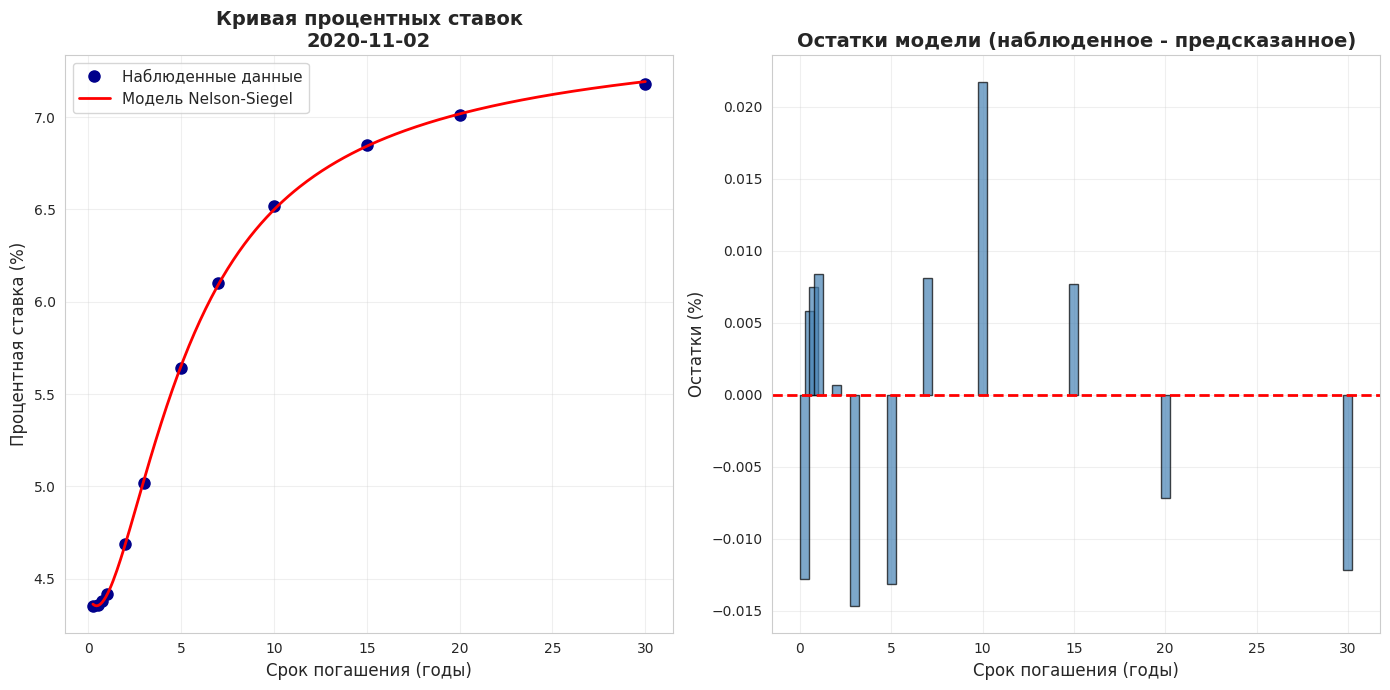

Максимальная ошибка: 0.0218%
Средняя абсолютная ошибка: 0.0100%


In [5]:
# Визуализация результатов для одной даты

# Создаем более плотную сетку для сглаженной кривой
tau_fine = np.linspace(maturities.min(), maturities.max(), 300)
predicted_fine = model.predict(tau_fine)
predicted_original = model.predict(maturities)

plt.figure(figsize=(14, 7))

# График 1: Исходные и предсказанные значения
plt.subplot(1, 2, 1)
plt.plot(maturities, yields_sample, 'o', markersize=8, label='Наблюденные данные', color='darkblue')
plt.plot(tau_fine, predicted_fine, '-', linewidth=2, label='Модель Nelson-Siegel', color='red')
plt.xlabel('Срок погашения (годы)', fontsize=12)
plt.ylabel('Процентная ставка (%)', fontsize=12)
plt.title(f'Кривая процентных ставок\n{sample_date.date()}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# График 2: Остатки (ошибки)
residuals = yields_sample - predicted_original
plt.subplot(1, 2, 2)
plt.bar(maturities, residuals, width=0.5, alpha=0.7, color='steelblue', edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Срок погашения (годы)', fontsize=12)
plt.ylabel('Остатки (%)', fontsize=12)
plt.title('Остатки модели (наблюденное - предсказанное)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Максимальная ошибка: {np.max(np.abs(residuals)):.4f}%")
print(f"Средняя абсолютная ошибка: {np.mean(np.abs(residuals)):.4f}%")

## Обучение модели на всем датасете

In [8]:
# Обучаем модель Nelson–Siegel для каждой даты в датасете
from tqdm.auto import tqdm

n_dates = len(df)
results = {
    'date': [],
    'beta0': [],
    'beta1': [],
    'beta2': [],
    'tau': [],
    'rmse': [],
    'r2': [],
    'mae': [],
    'convergence': []
}

print(f"Обучение модели Nelson–Siegel на {n_dates} датах...\n")

for date_idx in tqdm(range(n_dates), desc="Обучение Nelson–Siegel"):
    date = df.index[date_idx]
    yields = df.iloc[date_idx].values

    # Создаем и обучаем модель
    model_temp = NelsonSiegelModel()
    model_temp.fit(maturities, yields, method='trf')

    # Сохраняем результаты
    results['date'].append(date)
    results['beta0'].append(model_temp.params[0])
    results['beta1'].append(model_temp.params[1])
    results['beta2'].append(model_temp.params[2])
    results['tau'].append(model_temp.params[3])

    # Метрики
    metrics = model_temp.score(maturities, yields)
    results['rmse'].append(metrics['RMSE'])
    results['r2'].append(metrics['R²'])
    results['mae'].append(metrics['MAE'])
    results['convergence'].append(model_temp.optimization_result.success)

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)
results_df.set_index('date', inplace=True)

print(f"\n✓ Модель успешно обучена на всех датах!")
print(f"✓ Успешная сходимость: {results_df['convergence'].sum()}/{n_dates} ({100*results_df['convergence'].mean():.1f}%)")
print(f"\nСредние метрики качества:")
print(f"  RMSE: {results_df['rmse'].mean():.4f}")
print(f"  R²: {results_df['r2'].mean():.4f}")
print(f"  MAE: {results_df['mae'].mean():.4f}")

Обучение модели Nelson–Siegel на 1256 датах...



Обучение Nelson–Siegel: 100%|██████████| 1256/1256 [00:02<00:00, 521.54it/s]


✓ Модель успешно обучена на всех датах!
✓ Успешная сходимость: 1256/1256 (100.0%)

Средние метрики качества:
  RMSE: 0.0209
  R²: 0.9957
  MAE: 0.0170


In [9]:
# Статистика параметров модели
print("Описательная статистика параметров модели Nelson–Siegel:\n")
print(results_df[['beta0', 'beta1', 'beta2', 'tau']].describe())

# Выводим первые несколько строк
print("\nПервые 10 результатов:")
print(results_df.head(10))

Описательная статистика параметров модели Nelson–Siegel:

             beta0        beta1        beta2          tau
count  1256.000000  1256.000000  1256.000000  1256.000000
mean     11.637552     0.074535    -1.305495     1.955335
std       2.811609     3.918307     4.734542     2.303329
min       7.163259    -5.595713   -14.784808     0.149762
25%       8.907176    -3.038391    -4.141233     0.803924
50%      11.937956    -0.765390    -2.283203     1.329405
75%      14.130864     2.314774     0.555895     1.896615
max      18.424715    10.798748    12.255980    25.506967

Первые 10 результатов:
               beta0     beta1     beta2       tau      rmse        r2  \
date                                                                     
2020-11-02  7.542166 -3.136388 -3.890271  1.494380  0.011209  0.999894   
2020-11-03  7.586113 -3.160176 -3.885877  1.576546  0.008895  0.999933   
2020-11-05  7.273294 -2.848939 -3.675045  1.678748  0.008704  0.999920   
2020-11-06  7.228226 -2.94

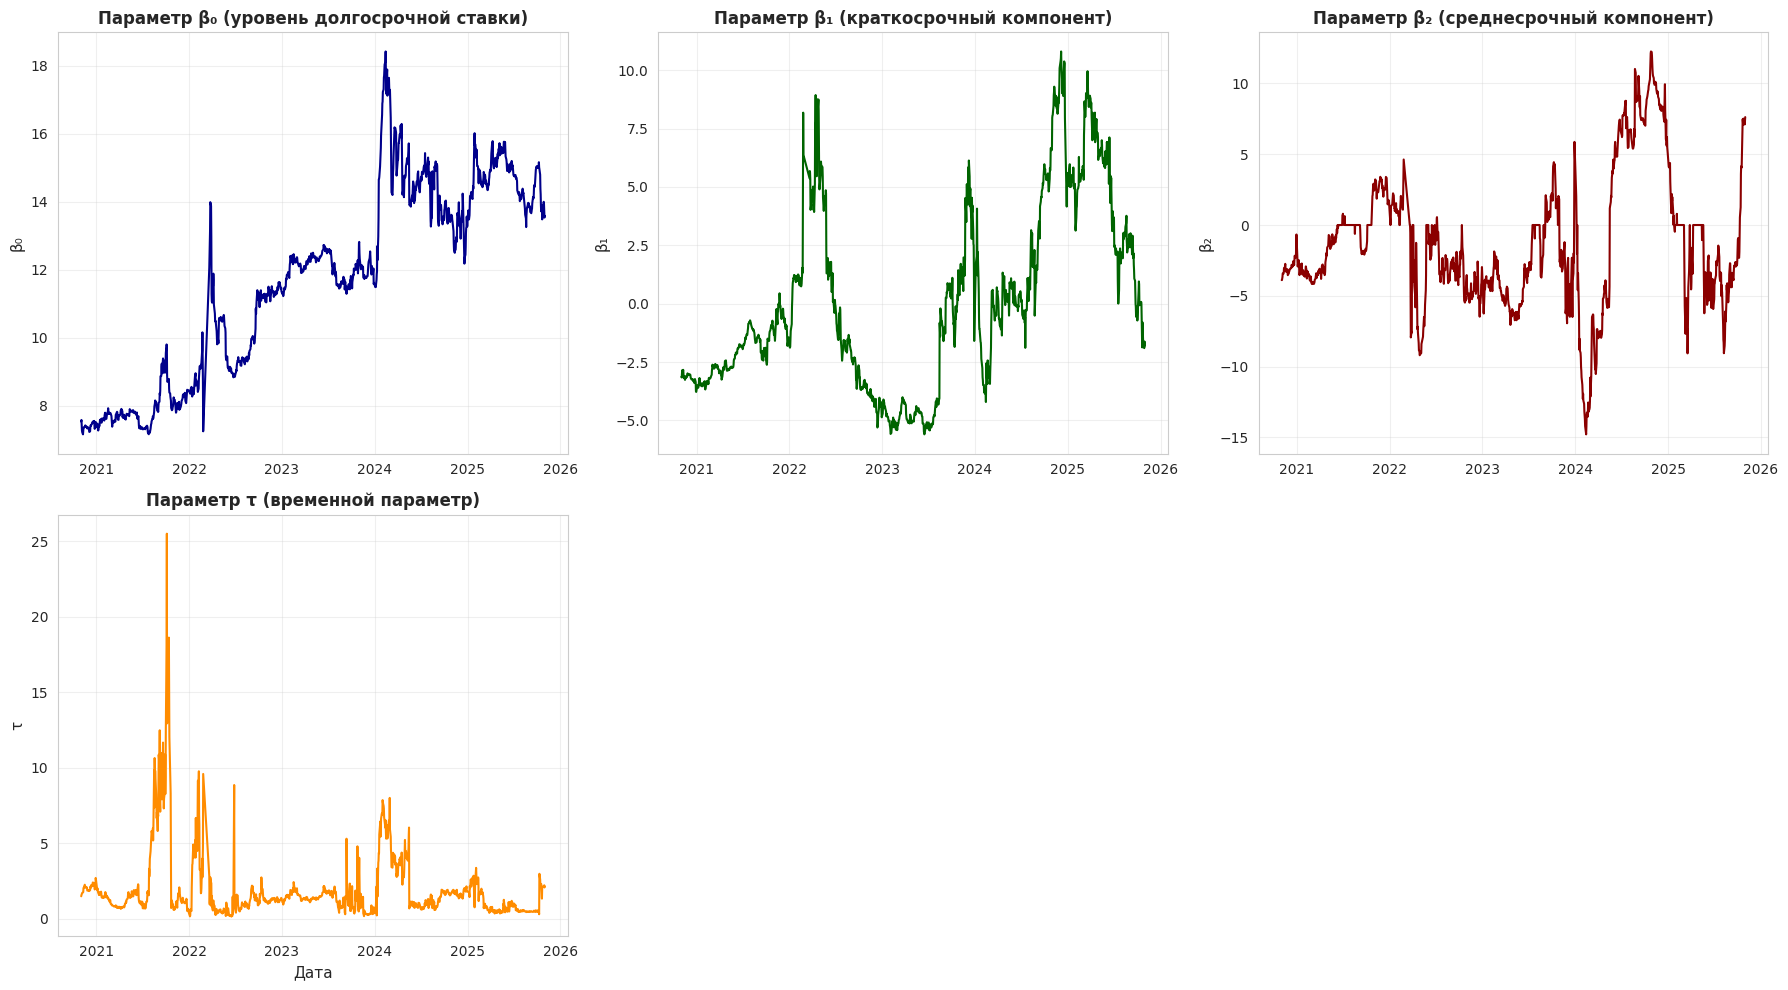

In [10]:
# Визуализация динамики параметров Nelson–Siegel во времени

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# β₀ (уровень)
axes[0, 0].plot(results_df.index, results_df['beta0'], linewidth=1.5, color='darkblue')
axes[0, 0].set_title('Параметр β₀ (уровень долгосрочной ставки)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('β₀', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# β₁ (краткосрочный компонент)
axes[0, 1].plot(results_df.index, results_df['beta1'], linewidth=1.5, color='darkgreen')
axes[0, 1].set_title('Параметр β₁ (краткосрочный компонент)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('β₁', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# β₂ (среднесрочный компонент)
axes[0, 2].plot(results_df.index, results_df['beta2'], linewidth=1.5, color='darkred')
axes[0, 2].set_title('Параметр β₂ (среднесрочный компонент)', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('β₂', fontsize=11)
axes[0, 2].grid(True, alpha=0.3)

# τ (временной параметр)
axes[1, 0].plot(results_df.index, results_df['tau'], linewidth=1.5, color='darkorange')
axes[1, 0].set_title('Параметр τ (временной параметр)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('τ', fontsize=11)
axes[1, 0].set_xlabel('Дата', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Пустые subplot'ы для симметрии
axes[1, 1].axis('off')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

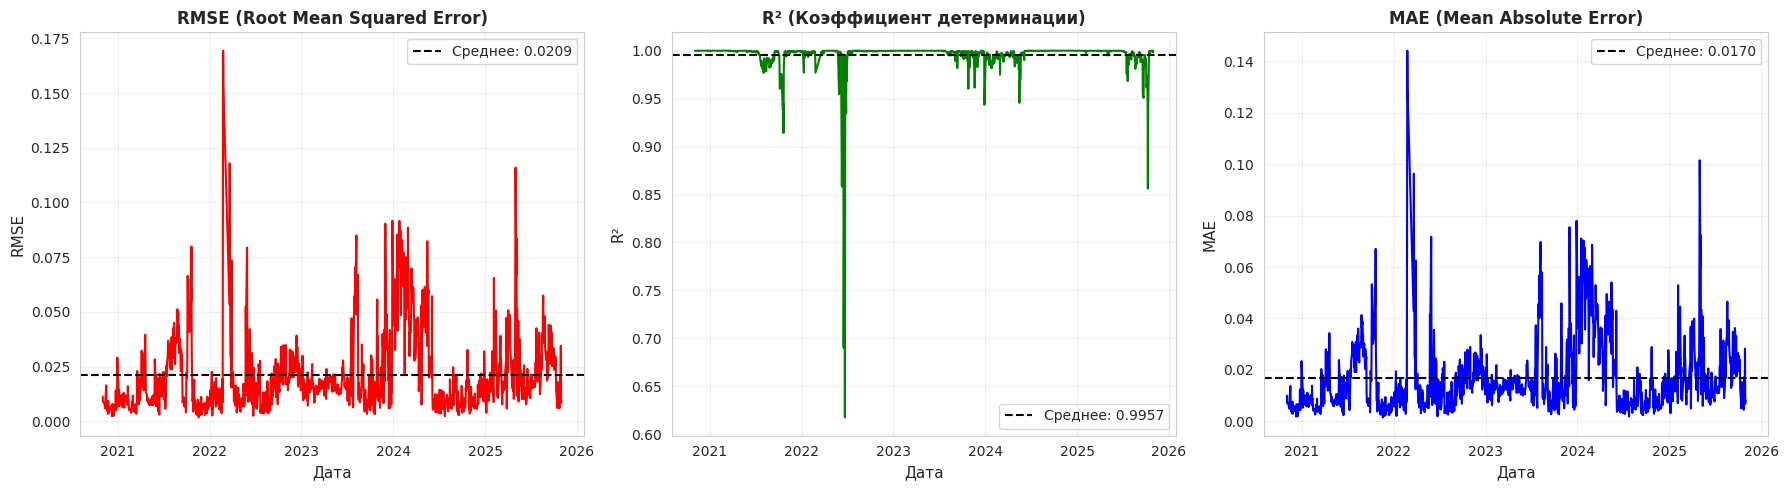

In [11]:
# Визуализация метрик качества модели

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
axes[0].plot(results_df.index, results_df['rmse'], linewidth=1.5, color='red')
axes[0].set_title('RMSE (Root Mean Squared Error)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RMSE', fontsize=11)
axes[0].set_xlabel('Дата', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=results_df['rmse'].mean(), color='black', linestyle='--',
                label=f'Среднее: {results_df["rmse"].mean():.4f}')
axes[0].legend()

# R²
axes[1].plot(results_df.index, results_df['r2'], linewidth=1.5, color='green')
axes[1].set_title('R² (Коэффициент детерминации)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R²', fontsize=11)
axes[1].set_xlabel('Дата', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=results_df['r2'].mean(), color='black', linestyle='--',
                label=f'Среднее: {results_df["r2"].mean():.4f}')
axes[1].legend()

# MAE
axes[2].plot(results_df.index, results_df['mae'], linewidth=1.5, color='blue')
axes[2].set_title('MAE (Mean Absolute Error)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('MAE', fontsize=11)
axes[2].set_xlabel('Дата', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=results_df['mae'].mean(), color='black', linestyle='--',
                label=f'Среднее: {results_df["mae"].mean():.4f}')
axes[2].legend()

plt.tight_layout()
plt.show()

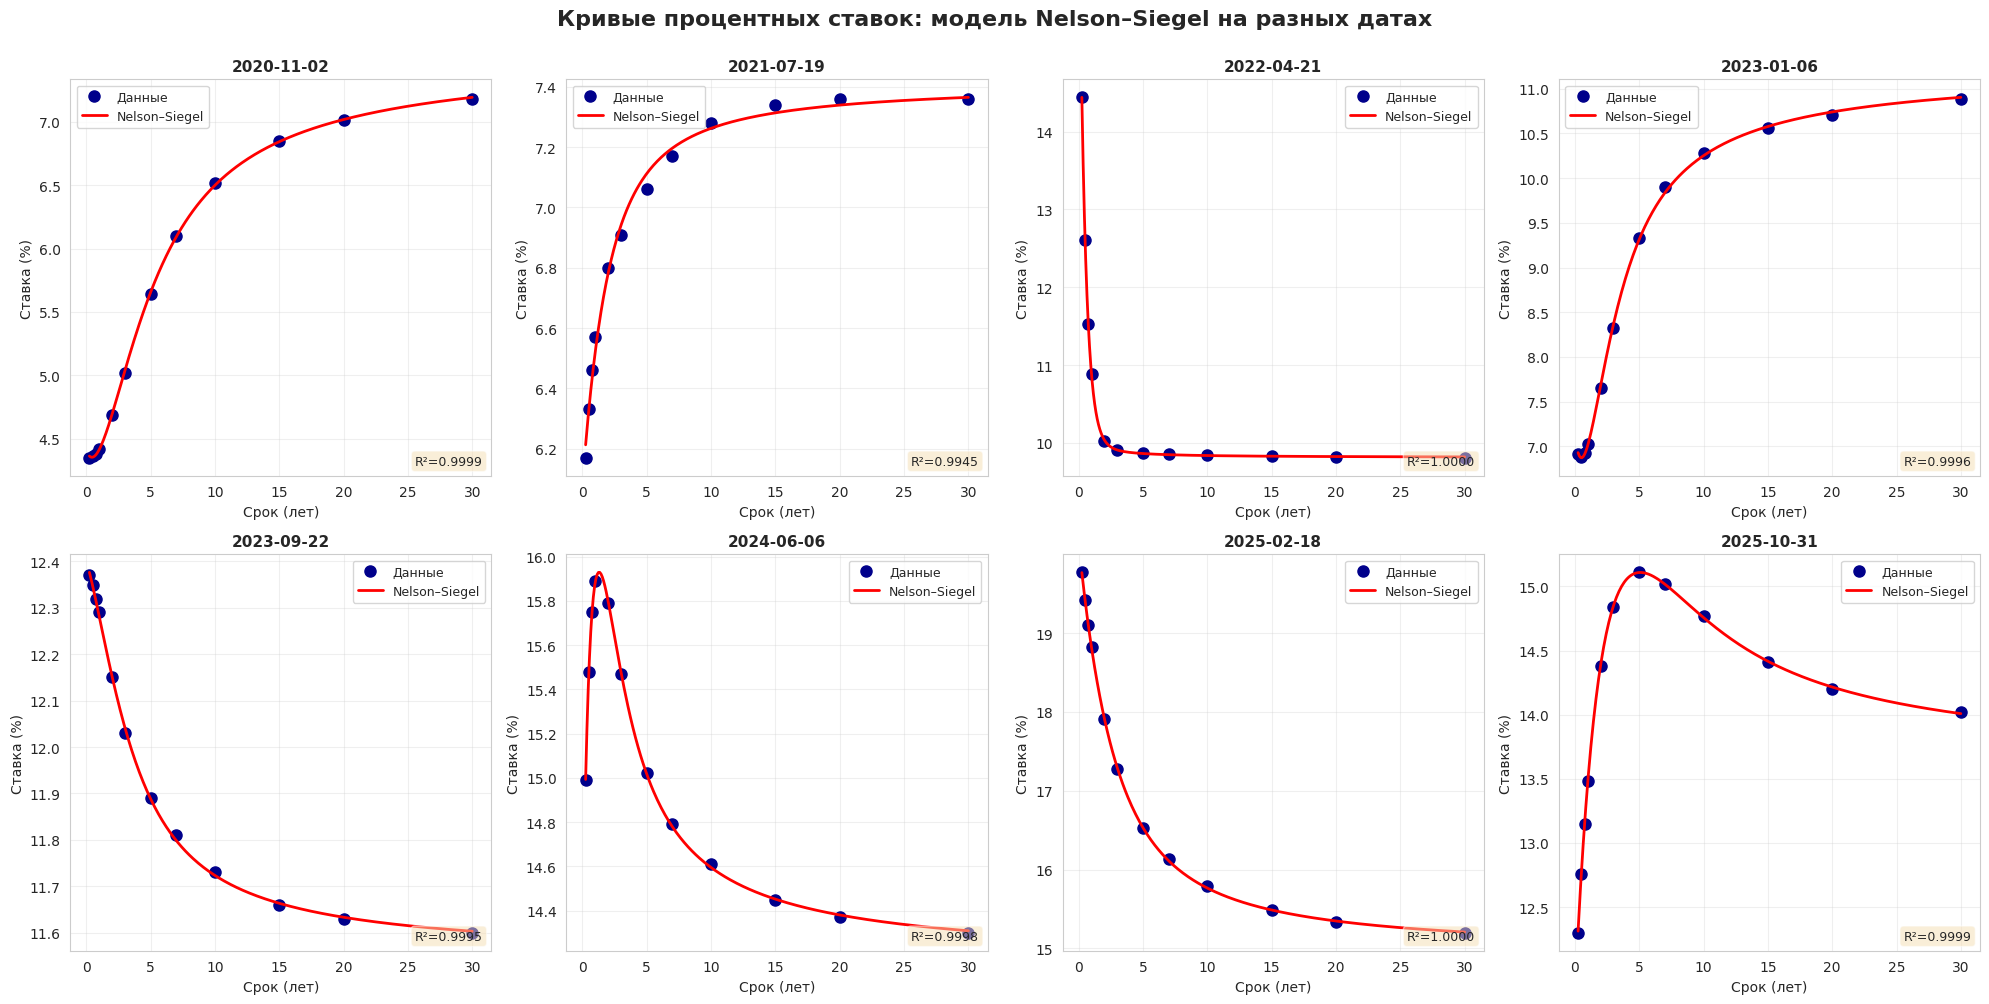

In [ ]:
# Визуализация кривых доходности для нескольких выбранных дат

# Выберем несколько равноотстоящих дат
n_samples = 8
indices = np.linspace(0, len(df)-1, n_samples, dtype=int)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

tau_fine = np.linspace(maturities.min(), maturities.max(), 300)

for i, idx in enumerate(indices):
    date = df.index[idx]
    yields = df.iloc[idx].values

    # Обучаем модель для этой даты
    model_viz = NelsonSiegelModel()
    model_viz.fit(maturities, yields, method='trf')

    # Предсказания
    predicted_fine = model_viz.predict(tau_fine)

    # График
    axes[i].plot(maturities, yields, 'o', markersize=8, label='Данные', color='darkblue')
    axes[i].plot(tau_fine, predicted_fine, '-', linewidth=2, label='Nelson–Siegel', color='red')
    axes[i].set_title(f'{date.date()}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Срок (лет)', fontsize=10)
    axes[i].set_ylabel('Ставка (%)', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

    # Добавим метрики на график
    metrics = model_viz.score(maturities, yields)
    axes[i].text(0.98, 0.02, f'R²={metrics["R²"]:.4f}',
                 transform=axes[i].transAxes, fontsize=9,
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Кривые процентных ставок: модель Nelson–Siegel на разных датах',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [13]:
# Сохранение результатов

# Сохраняем результаты в CSV
output_file = 'nelson_siegel_results.csv'
results_df.to_csv(output_file)
print(f"✓ Результаты сохранены в файл: {output_file}")

summary = {
    'Метрика': ['RMSE (среднее)', 'RMSE (мин)', 'RMSE (макс)',
                'R² (среднее)', 'R² (мин)', 'R² (макс)',
                'MAE (среднее)', 'MAE (мин)', 'MAE (макс)',
                'Успешная сходимость (%)'],
    'Значение': [
        results_df['rmse'].mean(),
        results_df['rmse'].min(),
        results_df['rmse'].max(),
        results_df['r2'].mean(),
        results_df['r2'].min(),
        results_df['r2'].max(),
        results_df['mae'].mean(),
        results_df['mae'].min(),
        results_df['mae'].max(),
        100 * results_df['convergence'].mean()
    ]
}

summary_df = pd.DataFrame(summary)
summary_file = 'nelson_siegel_summary.csv'
summary_df.to_csv(summary_file, index=False)
print(f"✓ Сводная статистика сохранена в файл: {summary_file}")

print("\nСводная статистика:")
print(summary_df.to_string(index=False))

✓ Результаты сохранены в файл: nelson_siegel_results.csv
✓ Сводная статистика сохранена в файл: nelson_siegel_summary.csv

Сводная статистика:
                Метрика   Значение
         RMSE (среднее)   0.020918
             RMSE (мин)   0.001766
            RMSE (макс)   0.169371
           R² (среднее)   0.995712
               R² (мин)   0.617576
              R² (макс)   0.999998
          MAE (среднее)   0.016986
              MAE (мин)   0.001507
             MAE (макс)   0.144159
Успешная сходимость (%) 100.000000


## Заключение

**Реализована модель Nelson–Siegel для моделирования кривой процентных ставок.**

**Модель**
- Формула: y(t) = β₀ + β₁ · [(1 − e^(−t/τ))/(t/τ)] + β₂ · [(1 − e^(−t/τ))/(t/τ) − e^(−t/τ)]
- Параметры: β₀ (уровень), β₁ (наклон), β₂ (кривизна), τ (временной параметр)

**Метод обучения**
- scipy.optimize.least_squares с методом 'trf' (Trust Region Reflective)
- Ограничение: τ > 0 (в реализации 0.05 ≤ τ ≤ 30.0)

**Ключевые результаты (из results_df)**
- Количество дат: 1256, успешная сходимость: 1256/1256 (100.0%)
- Средние метрики: RMSE ≈ 0.0209, R² ≈ 0.9957, MAE ≈ 0.0170
- Примерные средние значения параметров: β₀ ≈ 11.6376, β₁ ≈ 0.0745, β₂ ≈ −1.3055, τ ≈ 1.9553

**Выводы**
- Nelson–Siegel обеспечивает плотную аппроксимацию кривых доходности на данном наборе данных (высокий R², низкие RMSE/MAE).
- Однопараметрический временной компонент τ даёт достаточную гибкость для смещения и ширины выпуклости в большинстве наблюдений.
- Модель простая и устойчивая: быстрая калибровка по датам и стабильная сходимость.
- В случаях более сложной формы кривой (двойная выпуклость и т.п.) целесообразно рассмотреть расширения (Bliss/двухпараметрный τ) или гибридные модели.